In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from enum import Enum
from typing import Any, List

In [2]:
calib = cv2.imread('../Lab5_dane/calib.png')[..., ::-1]
test = cv2.imread('../Lab5_dane/test.png')[..., ::-1]
test_line = cv2.imread('../Lab5_dane/test_line.png')[..., ::-1]

In [3]:
!mkdir images

A subdirectory or file images already exists.


### Oddzielenie pudełka od tła (SLIC)

In [4]:
def segment_img(img, **kwargs):
    # PARAMETRY KWARGS
    n_segments = kwargs.get('n_segments')
    sigma = kwargs.get('sigma')
    K = kwargs.get('K')
    bestLabels = kwargs.get('bestLabels')
    criteria = kwargs.get('criteria')
    attempts = kwargs.get('attempts')
    flags = kwargs.get('flags')
    # STWORZENIE SUPERPIKSELI
    segments = slic(img, n_segments = n_segments, sigma = sigma)
    unique_segments = np.unique(segments)
    segments_colors = list()
    # UTWORZENIE REPREZENTACJI SUPERPIKSELA
    for segment in unique_segments:
        segment_pixels = img[segments == segment]
        mean_color = segment_pixels.mean(axis = 0).round(0)
        segments_colors.append(mean_color)
        
    segments_colors = np.array(segments_colors)
    kmeans_colors = np.float32(np.expand_dims(segments_colors, axis = 1))
    # KMEANS
    _, labels, _ = cv2.kmeans(data = kmeans_colors, K = K, 
                              bestLabels = bestLabels, 
                              criteria = criteria,
                              attempts = attempts,
                              flags = flags)
    # SEGMENTACJA OBIEKTU
    dct = dict(zip(unique_segments, labels))
    final_img = np.vectorize(lambda x: dct.get(x, x))(segments)
    # Znajdź najczęściej występującą etykietę i uznaj ją za tło (czarne)
    unique, counts = np.unique(final_img, return_counts=True)
    background_label = unique[np.argmax(counts)]
    # Przypisz tło jako czarne, a obiekt jako biały
    binary_output = np.where(final_img == background_label, 0, 255).astype(np.uint8)

    return binary_output




def extract_object(img, mask):
    img_copy = img.copy()
    img_copy[mask == 0] = 0
    return img_copy

In [5]:
PARAMS = {'n_segments': 100,
        'sigma': 1,
        'K': 2,
        'bestLabels': None,
        'criteria': (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0),
        'attempts': 20,
        'flags': cv2.KMEANS_RANDOM_CENTERS}

PARAMS2 = {'n_segments': 150,
        'sigma': .6,
        'K': 2,
        'bestLabels': None,
        'criteria': (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0),
        'attempts': 20,
        'flags': cv2.KMEANS_RANDOM_CENTERS}

PARAMS3 = {'n_segments': 150,
        'sigma': .6,
        'K': 2,
        'bestLabels': None,
        'criteria': (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0),
        'attempts': 20,
        'flags': cv2.KMEANS_RANDOM_CENTERS}

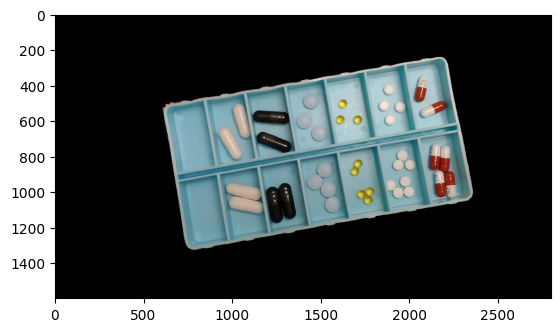

In [6]:
superpxl = segment_img(cv2.GaussianBlur(cv2.cvtColor(calib, cv2.COLOR_RGB2HLS), (21, 21), sigmaX = 0), **PARAMS)
pillbox = extract_object(calib, superpxl)
plt.imshow(pillbox)

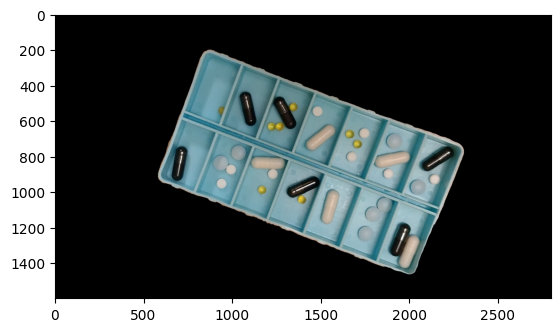

In [7]:
superpxl_test = segment_img(cv2.GaussianBlur(cv2.cvtColor(test, cv2.COLOR_RGB2HLS), (21, 21), sigmaX = 0), **PARAMS2)
pillbox_test = extract_object(test, superpxl_test)
plt.imshow(pillbox_test)

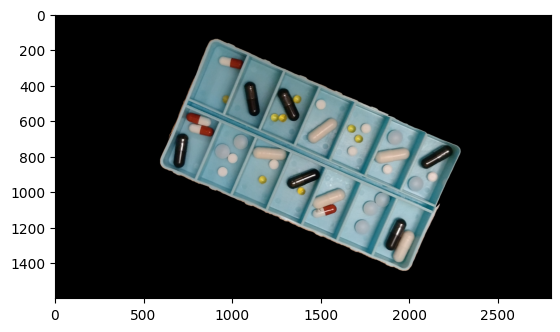

In [8]:
superpxl_test_line = segment_img(cv2.GaussianBlur(cv2.cvtColor(test_line, cv2.COLOR_RGB2HLS), (21, 21), sigmaX = 0), **PARAMS3)
pillbox_test_line = extract_object(test_line, superpxl_test_line)
plt.imshow(pillbox_test_line)

In [9]:
np.save('images/pillbox.npy', pillbox)
np.save('images/test.npy', pillbox_test)
np.save('images/line.npy', pillbox_test_line)

### Wydzielenie komórek pudełka jako ROI (Transformacja Hougha)

In [10]:
pillbox = np.load('images/pillbox.npy')
pillbox_test = np.load('images/test.npy')
pillbox_test_line = np.load('images/line.npy')

In [11]:
gray_pillbox = cv2.cvtColor(pillbox, cv2.COLOR_RGB2GRAY)
blurred_pillbox = cv2.GaussianBlur(gray_pillbox, (5, 5), 0)
canny_pillbox = cv2.Canny(blurred_pillbox, threshold1 = 60, threshold2 = 120, edges = None, apertureSize = 3)

gray_test = cv2.cvtColor(pillbox_test, cv2.COLOR_RGB2GRAY)
blurred_test = cv2.GaussianBlur(gray_test, (7, 7), 0)
canny_test = cv2.Canny(blurred_test, threshold1 = 10, threshold2 = 100, edges = None, apertureSize = 3)

gray_line = cv2.cvtColor(pillbox_test_line, cv2.COLOR_RGB2GRAY)
blurred_line = cv2.GaussianBlur(gray_line, (11, 11), 0)
canny_line = cv2.Canny(blurred_line, threshold1 = 10, threshold2 = 40, edges = None, apertureSize = 3)

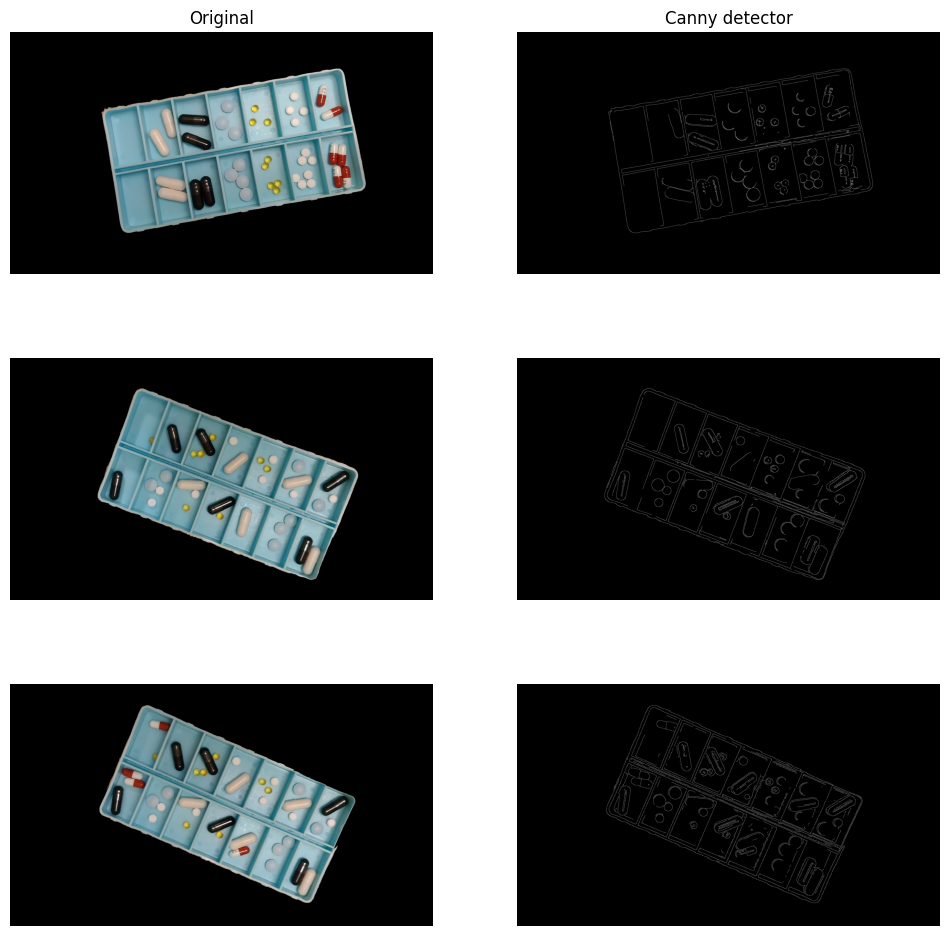

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0][0].imshow(pillbox)
axs[0][0].set_title('Original')
axs[0][0].axis('off')
axs[0][1].imshow(canny_pillbox, cmap = 'gray')
axs[0][1].set_title('Canny detector')
axs[0][1].axis('off')

axs[1][0].imshow(pillbox_test)
axs[1][0].axis('off')
axs[1][1].imshow(canny_test, cmap = 'gray')
axs[1][1].axis('off')

axs[2][0].imshow(pillbox_test_line)
axs[2][0].axis('off')
axs[2][1].imshow(canny_line, cmap = 'gray')
axs[2][1].axis('off')

plt.show()

In [13]:
def split_cells(img, canny_img):
    
    IMG_COPY = img.copy()
    BLACK_BACKGROUND = cv2.cvtColor(IMG_COPY, cv2.COLOR_RGB2GRAY)
    BLACK_BACKGROUND[BLACK_BACKGROUND == 0] = 255
    BLACK_BACKGROUND[BLACK_BACKGROUND != 0] = 255
    FILTERED_LINES = []
    
    def rhotheta2xy(rho, theta):
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 5000*(-b))
        y1 = int(y0 + 5000*(a))
        x2 = int(x0 - 5000*(-b))
        y2 = int(y0 - 5000*(a))
        return x1, y1, x2, y2
    
    lines = cv2.HoughLines(image = canny_img, 
                        rho = 1.1, 
                        theta = np.pi / 180, 
                        threshold = 220, 
                        lines = None, 
                        srn = 0, 
                        stn = 0)
    
    for rho, theta in lines[:, 0]:
        add_line = True
        for frho, ftheta in FILTERED_LINES:
            if abs(rho - frho) < 100 and abs(theta - ftheta) < np.deg2rad(10):
                add_line = False
                break
        if add_line:
            FILTERED_LINES.append((rho, theta))
    
    if FILTERED_LINES is not None: 
        for rho, theta in FILTERED_LINES:
            x1, y1, x2, y2 = rhotheta2xy(rho, theta)
            pt1 = x1, y1
            pt2 = x2, y2
            cv2.line(IMG_COPY, pt1, pt2, (255, 0, 0), 2, cv2.LINE_AA)
            cv2.line(BLACK_BACKGROUND, pt1, pt2, (0, 0, 0), 2, cv2.LINE_AA)
            
    return IMG_COPY, BLACK_BACKGROUND

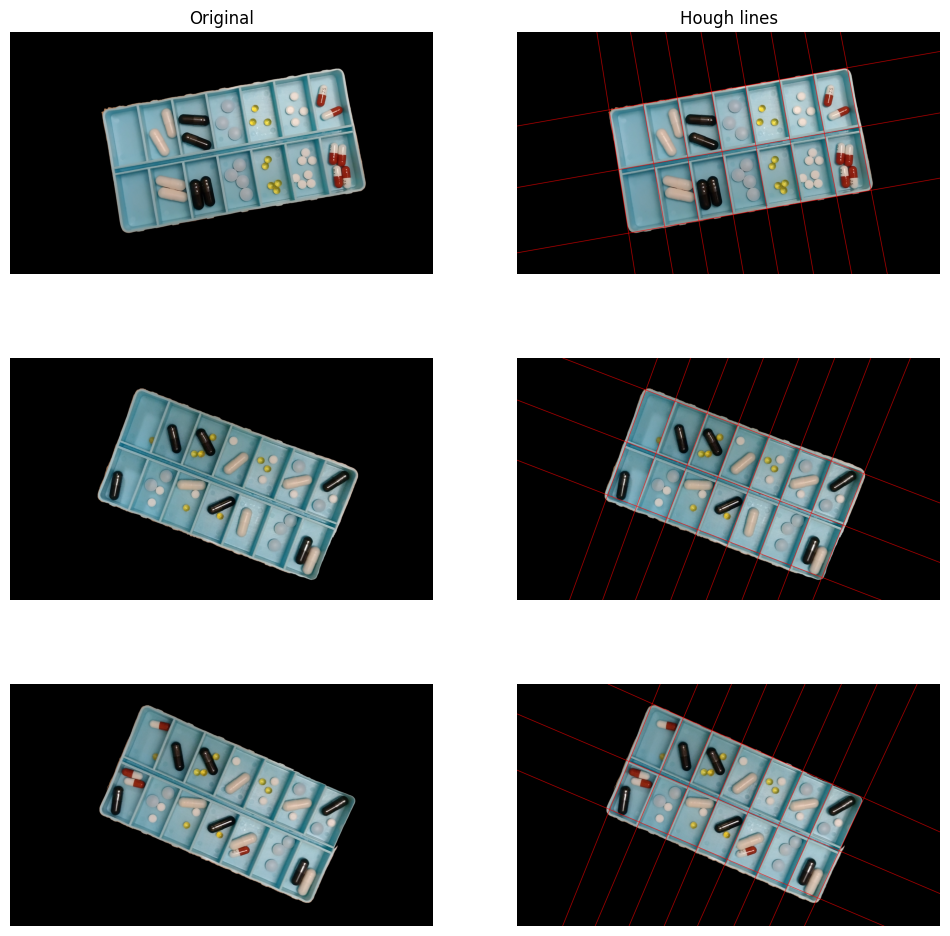

In [14]:
hough_pillbox, background_pillbox = split_cells(pillbox, canny_pillbox)
hough_test, background_test = split_cells(pillbox_test, canny_test)
hough_line, background_line = split_cells(pillbox_test_line, canny_line)


fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0][0].imshow(pillbox)
axs[0][0].set_title('Original')
axs[0][0].axis('off')
axs[0][1].imshow(hough_pillbox, cmap = 'gray')
axs[0][1].set_title('Hough lines')
axs[0][1].axis('off')

axs[1][0].imshow(pillbox_test)
axs[1][0].axis('off')
axs[1][1].imshow(hough_test, cmap = 'gray')
axs[1][1].axis('off')

axs[2][0].imshow(pillbox_test_line)
axs[2][0].axis('off')
axs[2][1].imshow(hough_line, cmap = 'gray')
axs[2][1].axis('off')

plt.show()

In [15]:
np.save('images/pillbox_hough.npy', hough_pillbox)
np.save('images/test_hough.npy', hough_test)
np.save('images/line_hough.npy', hough_line)

np.save('images/pillbox_background.npy', background_pillbox)
np.save('images/test_background.npy', background_test)
np.save('images/line_background.npy', background_line)